In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
import pandas
import scipy.stats
from matplotlib import pyplot

import calibr8

### Generating fake data
For this demonstration, we'll assume that we have prepared a calibration curve of 24 data points.

Furthermore, we'll assume that the dependency between the independent variable (OD600) and the dependent variable (A600) is linear, with the following formula:

$$y = \theta_0 + \theta_1 \cdot x$$

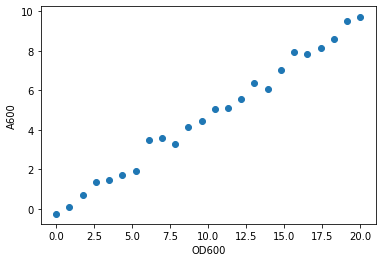

In [3]:
cal_x = numpy.linspace(0.001, 20, 24)
cal_y = numpy.random.normal(0.04 + 0.48 * cal_x, scale=0.3)

fig, ax = pyplot.subplots()
ax.scatter(cal_x, cal_y)
ax.set_ylabel('A600')
ax.set_xlabel('OD600')
pyplot.show()

### Implementation of the error model
`calibr8` has an abstract class `ErrorModel` that is designed to generalize over a wide range of applications.

The error model has several methods that need to be implemented by the user. Most importantly:
+ `predict_dependent`, which predicts the parameters of the probability distribution describing the measurement noise (noise of A600) at for a given independent variable (OD600)
+ `predict_independent`, which is the inverse of the method above (calculating OD600 from A600)
+ `loglikelihood` computes $\sum{ln{\mathcal{L}(\theta \mid A_{600}, OD_{600})}}$, which is required for the maximum-likelihood estimation

In reality, the error models are almost never linear. To make it easier to build non-linear error models, `calibr8` implements several model functions, such as `logstic` or `asymmetric_logistic`.

In [4]:
class LinearErrorModel(calibr8.ErrorModel):
    def __init__(self):
        # set name of the independent variable to 'OD600'
        # set name of the dependent variable to 'A600'
        super().__init__('OD600', 'A600')
        
    def predict_dependent(self, y_hat, *, theta=None):
        """Predicts the parameters mu and sigma of a student-t-distribution which characterises the dependent variable
           given values of the independent variable.

        Args:
            y_hat (array): values of the independent variable
            theta: parameters describing the linear function of mu and the constant function of sigma (default to self.theta_fitted)

        Returns:
            mu, sigma (array): values for mu and sigma characterising the Normal distributions describing the dependent variable
        """
        if theta is None:
            theta = self.theta_fitted
        mu = theta[0] + theta[1] * numpy.array(y_hat)
        sigma = theta[2]
        return mu, sigma
    
    def predict_independent(self, y_obs):
        """Predict the most likely value of the independent variable using the calibrated error model in inverse direction.

        Args:
            y_obs (array): measurements of the dependent variable

        Returns:
            mu (array): predicted independent variables given the observations
        """
        a, b, sigma = self.theta_fitted
        mu = (y_obs - a) / b
        return mu

    def loglikelihood(self, *, y,  x, theta=None):
        """Loglikelihood of observation (dependent variable) given the independent variable

        Args:
            y (array): measurements of the dependent variable
            x (array): predicted independent variables
            theta: parameters describing the logistic function of mu and the polynomial function of sigma 
                   (to be fitted with data, otherwise theta=self.theta_fitted)
        
        Return:
            Sum of loglikelihoods
        """
        if theta is None:
            if self.theta_fitted is None:
                raise Exception('No parameter vector was provided and the model is not fitted with data yet.')
            theta = self.theta_fitted

        mu, sigma = self.predict_dependent(x, theta=theta)
        # using t-distributed error in the non-transformed space
        likelihoods = scipy.stats.norm.pdf(x=y, loc=mu, scale=sigma)
        loglikelihoods = numpy.log(likelihoods)
        ll = numpy.sum(loglikelihoods)
        return ll

### Create and fit the error model
Now the error model can be instantiated and fitted.
For fitting, we'll need to supply our calibration data (`cal_x` and `cal_y`), as well as initial guesses & bounds for the model parameters.

The result of the fit indices if the fitting procedure was successful:

```
 status: 0
success: True
      x: array([0.1739296 , 0.46682245, 0.12950334])
```

In [5]:
em = LinearErrorModel()

em.fit(independent=cal_x, dependent=cal_y,
      theta_guessed=[0.1, 0.5, 0.2],
      bounds=[
          (-0.5, 0.5),  # lower/upper bound of y-intercept
          (0.1, 3),     # lower/upper bound of slope
          (0.01, 0.5),  # lower/upper bound of measurement noise
      ])

      fun: 4.067573270675119
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.06945572e-05,  9.22817378e-05, -1.77635684e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 18
   status: 0
  success: True
        x: array([-0.21037832,  0.49216951,  0.2866606 ])

### Visualize the fitted error model
Now, the fitted model can be visualized in terms of the most-likely measurement outcomes (solid line) and intervals where 68, 90 and 95 % of measurements will fall.

In [6]:
 def plot_norm_band(ax, d, mu, scale):
    """Helper function for plotting the likeihood-bands of a Normal distribution."""
    ax.plot(d, mu, color='green')
    for q in reversed([97.5, 95, 84]):
        percent = q - (100 - q)
        ax.fill_between(d,
            # by using the Percent Point Function (PPF), which is the inverse of the CDF,
            # the visualization will show symmetric intervals of <percent> probability
            scipy.stats.norm.ppf(1-q/100, loc=mu, scale=scale),
            scipy.stats.norm.ppf(q/100, loc=mu, scale=scale),
            alpha=.15, color='green', label=f'{percent:.1f} % likelihood band'
        )
    return

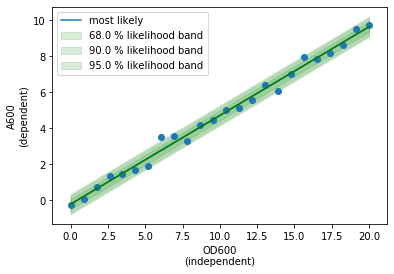

In [7]:
fig, ax = pyplot.subplots()
# plot fitted model
x_dense = numpy.linspace(0, 20, 100)
mu, scale = em.predict_dependent(x_dense)
ax.plot(x_dense, mu, label='most likely')

plot_norm_band(ax, x_dense, mu, scale)

# plot data
ax.scatter(cal_x, cal_y)
ax.set_ylabel('A600\n(dependent)')
ax.set_xlabel('OD600\n(independent)')
ax.legend()
pyplot.show()

### Using the model
The model can be used in two directions:
1. predicting where measurements will fall, given a certain value of the independent variable
2. predicting the most likely independent variable, given a certain observation of the dependent variable

More advanced methods are available too, but not shown in this example.

In [8]:
OD600 = 10.5
mu, sigma = em.predict_dependent(OD600)

print(f'For OD600={OD600}, we expect to observe A600 = {mu:.2f} ± {sigma:.2f}')

For OD600=10.5, we expect to observe A600 = 4.96 ± 0.29


In [9]:
A600 = 4.0
od = em.predict_independent(A600)

print(f'An absorbance measurement of A600={A600} is most likely when OD600={od:.2f}')

An absorbance measurement of A600=4.0 is most likely when OD600=8.55
